In [1]:
from google.colab import files

uploaded = files.upload()

Saving Final_preprocessing (1).zip to Final_preprocessing (1).zip


In [2]:
import zipfile
import os

# 압축 파일 경로
zip_path = '/content/Final_preprocessing (1).zip'
extract_dir = '/content/Final_preprocessing (1)_dataset'

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ 압축 해제 완료!")

✅ 압축 해제 완료!


In [1]:
# 라이브러리
import os
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torchvision.models import resnet18, efficientnet_b0, inception_v3, resnet50, convnext_tiny,densenet121
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from tqdm import tqdm

In [2]:
# Seed 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
# 학습용 transform (Augmentation C4 조합)
aug_c4 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7603, 0.5931, 0.5682],
                         std=[0.1943, 0.1956, 0.2142])
])

In [4]:
# 평가 및 테스트용 transform
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7603, 0.5931, 0.5682],
                         std=[0.1943, 0.1956, 0.2142])
])

In [5]:
# Balanced Sampler 함수
def get_balanced_sampler(csv_file):
    df = pd.read_csv(csv_file)
    class_counts = df['target'].value_counts().to_dict()
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = df['target'].map(class_weights).values
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

In [6]:
# 데이터셋 클래스
class MelanomaDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['filename']
        label = self.df.iloc[idx]['target']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [7]:
# 모델 정의
def get_conv():
    model = convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 1)  # Sigmoid 제거
    return model

In [8]:
# 평가 함수
# evaluate 수정
def evaluate(model, dataloader, criterion):
    model.eval()
    preds, trues, probs = [], [], []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.cuda()
            labels = labels.cuda().float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            prob = torch.sigmoid(outputs)
            predicted = (prob > 0.5).float()

            probs.extend(prob.cpu().numpy())
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    # 성능 지표 계산
    acc = accuracy_score(trues, preds)
    recall = recall_score(trues, preds)
    precision = precision_score(trues, preds)
    f1 = f1_score(trues, preds)
    avg_loss = running_loss / len(dataloader)

    # Confusion Matrix 출력
    cm = confusion_matrix(trues, preds)
    print(f"Confusion Matrix:\n{cm}")

    # Confusion Matrix 계산
    cm = confusion_matrix(trues, preds)

    # 시각화
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC-AUC Score 계산
    try:
        auc = roc_auc_score(trues, probs)
        print(f"ROC-AUC Score: {auc:.4f}")
    except:
        print("ROC-AUC 계산 불가 (단일 클래스 문제일 수 있음)")

    return avg_loss, acc, recall, precision, f1

In [9]:
# 학습 함수
# train_one_epoch 수정
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    preds, trues = [], []

    for images, labels in tqdm(dataloader):
        images = images.cuda()
        labels = labels.cuda().float().unsqueeze(1)  # [batch_size, 1]로 고정

        optimizer.zero_grad()
        outputs = model(images)  # ✅ squeeze 제거
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).float()
        preds.extend(predicted.cpu().detach().numpy())
        trues.extend(labels.cpu().detach().numpy())

    acc = accuracy_score(trues, preds)
    recall = recall_score(trues, preds)
    precision = precision_score(trues, preds)
    f1 = f1_score(trues, preds)
    avg_loss = running_loss / len(dataloader)

    return avg_loss, acc, recall, precision, f1

In [10]:
# 데이터 로딩
train_dataset = MelanomaDataset('/content/Final_preprocessing (1)_dataset/final_dataset/train', '/train_labels.csv', transform=aug_c4)
val_dataset = MelanomaDataset('/content/Final_preprocessing (1)_dataset/final_dataset/val', '/val_labels.csv', transform=transform_eval)
test_dataset = MelanomaDataset('/content/Final_preprocessing (1)_dataset/final_dataset/test', '/test_labels.csv', transform=transform_eval)

In [11]:
# Balanced Sampler 적용
sampler = get_balanced_sampler('/train_labels.csv')

## 실험 1: batch_size = 32 ##
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# 모델, 손실함수, 옵티마이저
model = get_conv().cuda()
criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Warm-up + CosineAnnealing Scheduler 설정
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

# Optimizer 정의
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Warm-up Scheduler 함수 정의
def warmup_scheduler(base_scheduler, warmup_epochs):
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        return 1.0
    return LambdaLR(optimizer, lr_lambda=lr_lambda)

# CosineAnnealing + Warm-up 스케줄러 조합
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)
scheduler = warmup_scheduler(cosine_scheduler, warmup_epochs=10)

In [14]:
# best model 기준값 및 저장 경로
best_val_loss = float('inf')
best_model_path = 'best_model.pth'

# EarlyStopping 변수
patience = 3
counter = 0

# Checkpoint 저장 폴더
os.makedirs("checkpoints", exist_ok=True)

In [15]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

100%|██████████| 132/132 [01:09<00:00,  1.89it/s]


Confusion Matrix:
[[642  33]
 [ 18 207]]


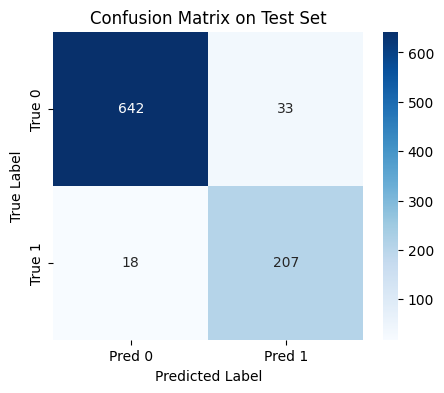

ROC-AUC Score: 0.9839


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Epoch 1]
Train - Loss: 0.2331 | Accuracy: 0.9002 | Recall: 0.8826 | Precision: 0.9129 | F1: 0.8975
 Val  - Loss: 0.1489 | Accuracy: 0.9433 | Recall: 0.9200 | Precision: 0.8625 | F1: 0.8903


100%|██████████| 132/132 [01:08<00:00,  1.93it/s]


Confusion Matrix:
[[656  19]
 [ 25 200]]


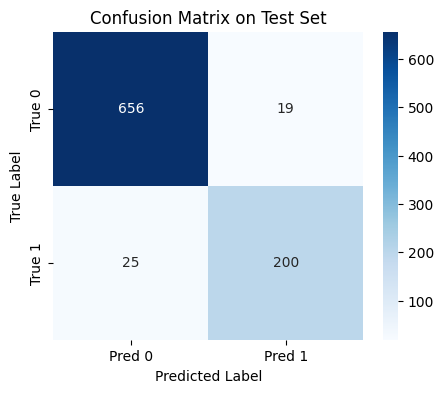

ROC-AUC Score: 0.9838


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Epoch 2]
Train - Loss: 0.1432 | Accuracy: 0.9424 | Recall: 0.9292 | Precision: 0.9530 | F1: 0.9409
 Val  - Loss: 0.1340 | Accuracy: 0.9511 | Recall: 0.8889 | Precision: 0.9132 | F1: 0.9009


100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Confusion Matrix:
[[653  22]
 [ 24 201]]


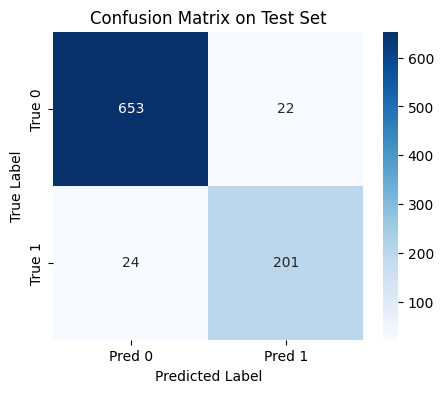

ROC-AUC Score: 0.9856


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Epoch 3]
Train - Loss: 0.1094 | Accuracy: 0.9574 | Recall: 0.9453 | Precision: 0.9680 | F1: 0.9565
 Val  - Loss: 0.1324 | Accuracy: 0.9489 | Recall: 0.8933 | Precision: 0.9013 | F1: 0.8973


100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Confusion Matrix:
[[638  37]
 [ 19 206]]


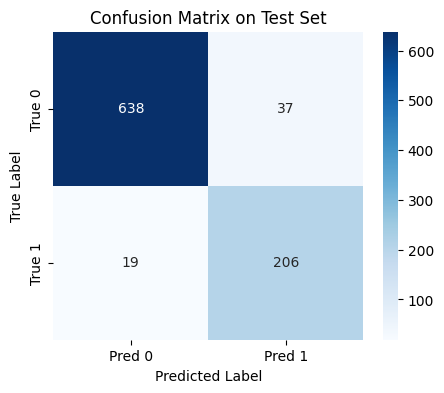

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


ROC-AUC Score: 0.9834
[Epoch 4]
Train - Loss: 0.0953 | Accuracy: 0.9640 | Recall: 0.9578 | Precision: 0.9702 | F1: 0.9640
 Val  - Loss: 0.1651 | Accuracy: 0.9378 | Recall: 0.9156 | Precision: 0.8477 | F1: 0.8803


100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Confusion Matrix:
[[657  18]
 [ 24 201]]


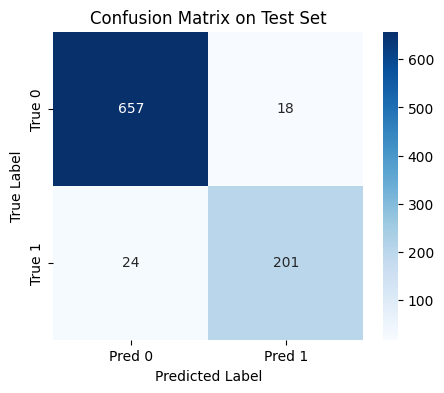

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


ROC-AUC Score: 0.9851
[Epoch 5]
Train - Loss: 0.0794 | Accuracy: 0.9717 | Recall: 0.9655 | Precision: 0.9772 | F1: 0.9713
 Val  - Loss: 0.1583 | Accuracy: 0.9533 | Recall: 0.8933 | Precision: 0.9178 | F1: 0.9054


100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Confusion Matrix:
[[649  26]
 [ 19 206]]


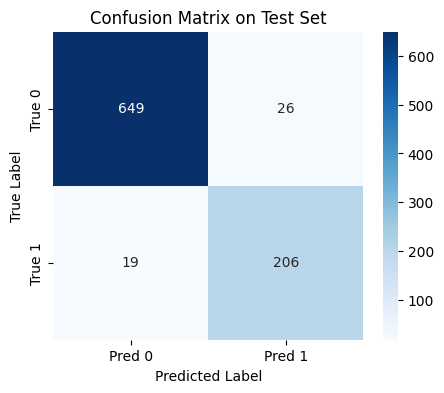

ROC-AUC Score: 0.9812
EarlyStopping triggered at epoch 6


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [16]:
# 학습 루프
for epoch in range(1, 101):
    train_loss, train_acc, train_rec, train_prec, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_rec, val_prec, val_f1 = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"EarlyStopping triggered at epoch {epoch}")
            break

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_epoch_{epoch}.pth")

    print(f"[Epoch {epoch}]")
    print(f"Train - Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f} | Recall: {train_rec:.4f} | Precision: {train_prec:.4f} | F1: {train_f1:.4f}")
    print(f" Val  - Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Recall: {val_rec:.4f} | Precision: {val_prec:.4f} | F1: {val_f1:.4f}")

# 에폭별 학습률 조정
scheduler.step()

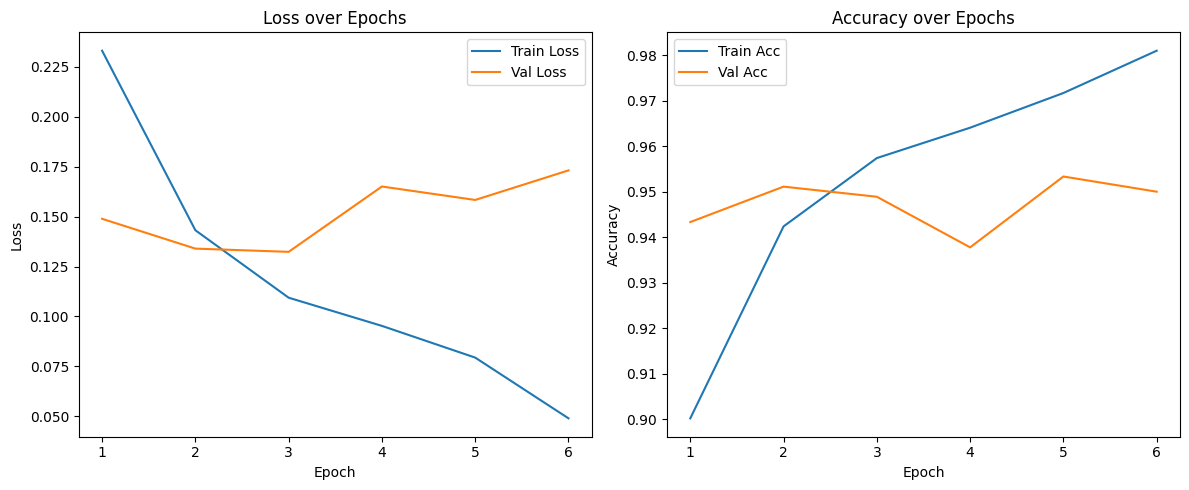

In [17]:
# 학습 및 검증 Loss / Accuracy 시각화
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix:
[[665  10]
 [ 24 201]]


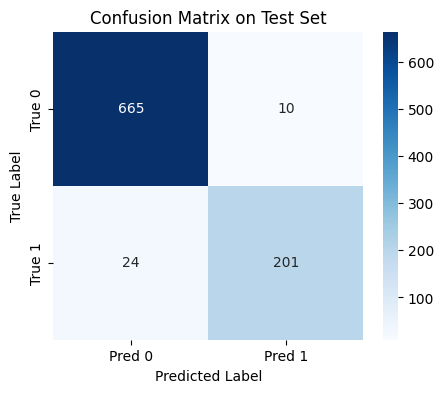

ROC-AUC Score: 0.9871

[Test] Loss: 0.1233 | Accuracy: 0.9622 | Recall: 0.8933 | Precision: 0.9526 | F1: 0.9220


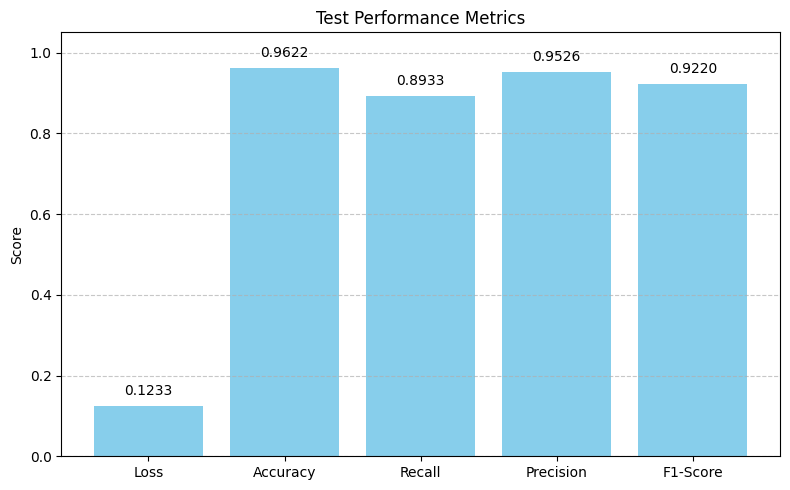

In [18]:
# Test 평가
model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc, test_rec, test_prec, test_f1 = evaluate(model, test_loader, criterion)
print(f"\n[Test] Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | Recall: {test_rec:.4f} | Precision: {test_prec:.4f} | F1: {test_f1:.4f}")

test_metrics = {
    "Loss": test_loss,
    "Accuracy": test_acc,
    "Recall": test_rec,
    "Precision": test_prec,
    "F1-Score": test_f1
}

plt.figure(figsize=(8, 5))
bars = plt.bar(test_metrics.keys(), test_metrics.values(), color='skyblue')
plt.ylim(0, 1.05)
plt.title("Test Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 각 막대 위에 값 표시 (소수점 4자리)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

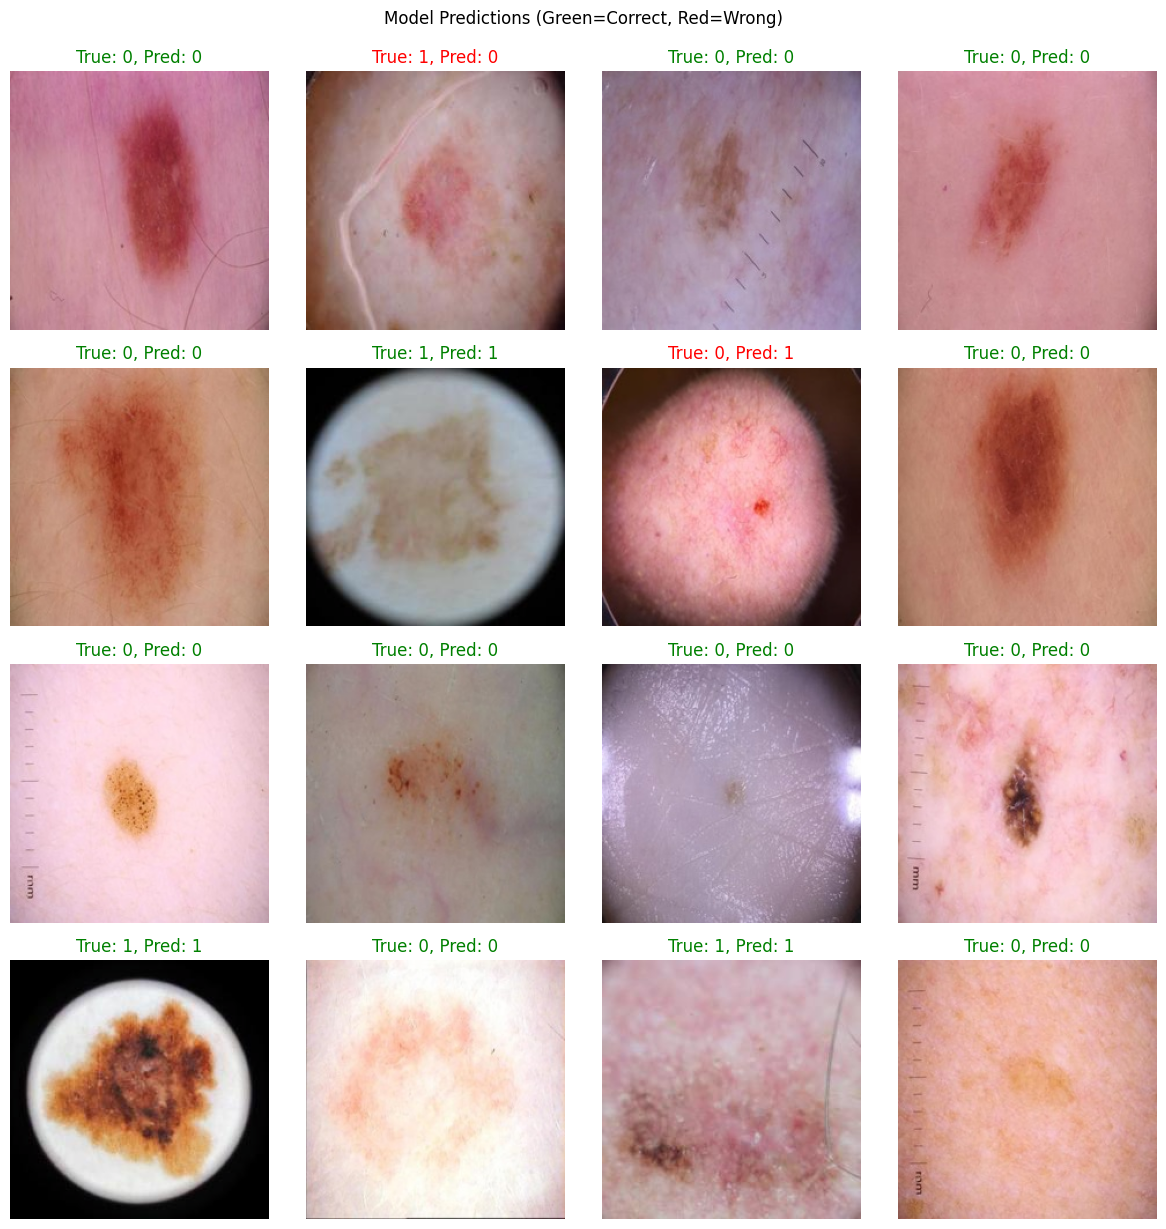

In [19]:
# 예측 결과 시각화 수
num_images = 16

# device -> cuda 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()
images_batch, true_labels, pred_labels = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        images_batch.extend(images.cpu())
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

        if len(images_batch) >= num_images:
            break

# De-normalization 값
mean = [0.7603, 0.5931, 0.5682]
std = [0.1943, 0.1956, 0.2142]

# 시각화
plt.figure(figsize=(12, 12))
for idx in range(num_images):
    img = images_batch[idx].permute(1, 2, 0).numpy()
    img = (img * std) + mean  # De-normalization
    img = np.clip(img, 0, 1)

    true_label = int(true_labels[idx][0]) if isinstance(true_labels[idx], np.ndarray) else int(true_labels[idx])
    pred_label = int(pred_labels[idx][0]) if isinstance(pred_labels[idx], np.ndarray) else int(pred_labels[idx])

    plt.subplot(4, 4, idx + 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}, Pred: {pred_label}', color="green" if true_label == pred_label else "red")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Model Predictions (Green=Correct, Red=Wrong)", y=1.02)
plt.show()